In [1]:
# import Serial libraries
import serial
import serial.tools.list_ports
import time
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *

In [6]:
# list serial ports
ports = list(serial.tools.list_ports.comports())
for p in ports:
    print(p) 

/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem1101 - Feather ESP32-S2


In [10]:
start = time.time()

sp = cartpole_open_serial("/dev/cu.usbmodem1101")
data = cartpole_safe_read(sp)
cartpole_close_serial(sp)

end = time.time()

print("time elapsed", end-start, "seconds")
data

time elapsed 0.020092010498046875 seconds


['4.074', '0.000', '1.584', '0.000', '4.715', '0.000', '0.000', '0.000']

In [32]:
control_frequency = 100 # Hz
control_period = 1/control_frequency
T = 5    # seconds
N = int(T*control_frequency) # number of control steps

data = np.zeros((N,3)) # initialize data array
control_input = np.zeros((N,2)) # initialize control input array
error_array = np.zeros((N,1)) # initialize error array
control_array = np.zeros((N,1)) # initialize control array
loop_time = []

elapsed_count = 0

kp = 30
kd = 1
last_error = 0

sp = cartpole_open_serial("/dev/cu.usbmodem1101")
cartpole_busy_sleep(1, loop_start = time.time())

for i in range(N):
    # read the encoder data
    # save the encoder data
    # write a 0 torque command
    # wait for the next control period

    time_start = time.time()

    encoder_data = cartpole_safe_read(sp)
    data[i,0] = encoder_data[0]
    data[i,1] = encoder_data[2]
    data[i,2] = encoder_data[4]

    control_input[i,0] = encoder_data[6]
    control_input[i,1] = encoder_data[7]

    error = (np.pi/2) - float(encoder_data[2])
    control = kp*error

    control = kp*error - (kd*(error - last_error)/control_period)

    if control > 0:
        control += 0.1
    else:
        control -= 0.2

    # clamp control to be between -1 and 1
    if control > 2:
        control = 2
    elif control < -2:
        control = -2

    error_array[i] = error
    control_array[i] = control
    
    cartpole_write_motors(sp,control,0)

    # if elapsed_count < N/2:
    #     cartpole_write_motors(sp,0,0)
    # else:
    #     cartpole_write_motors(sp,0,0)

    elapsed_count += 1
    loop_time.append(time.time() - time_start)
    cartpole_busy_sleep(control_period, loop_start = time_start)

# cartpole_write_motors(sp,0,0)
cartpole_close_serial(sp)

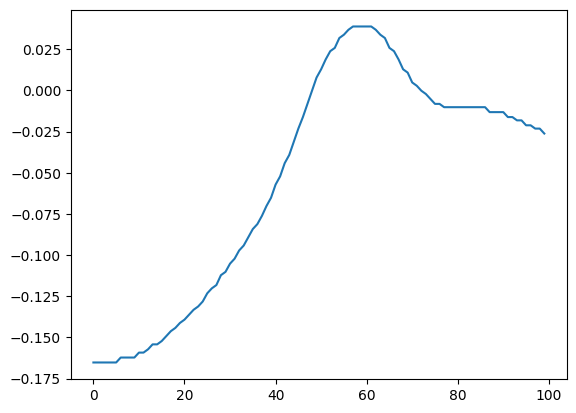

In [9]:
plt.plot(error_array, label = "error")

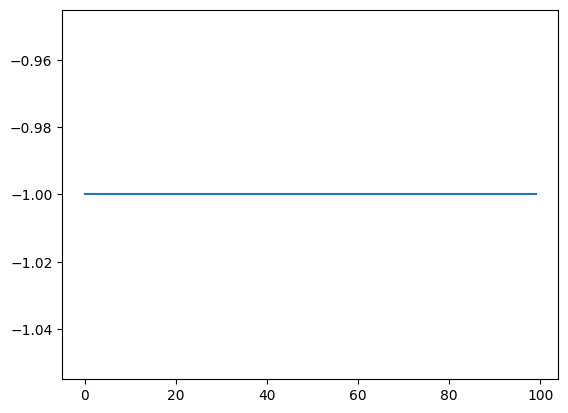

In [69]:
plt.plot(control_array, label = "control")

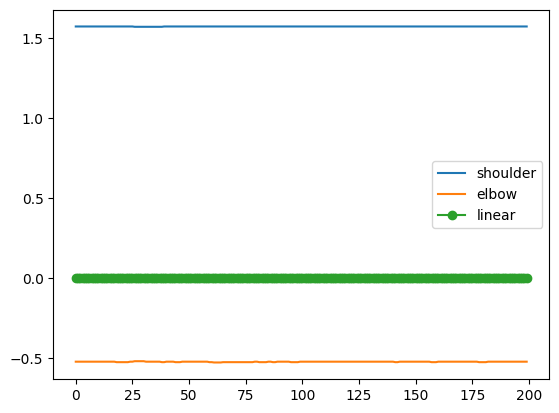

In [58]:
# plot the data
# plt.plot(data[:,0], label = "linear")
plt.plot(data[:,1], label = "shoulder")
plt.plot(data[:,2], label = "elbow")
plt.plot(control_input[:,0] * 10, label = "linear", marker = "o") 
plt.legend()

plt.show()

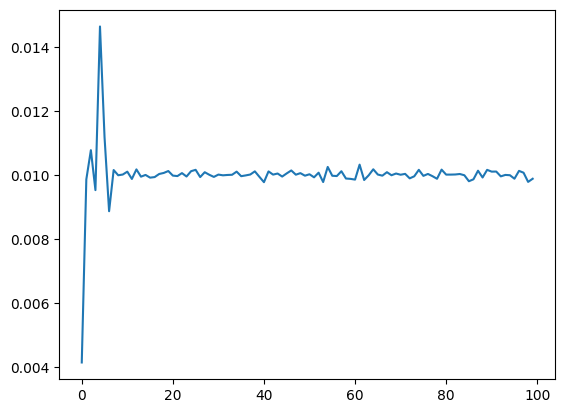

In [23]:
loop_time = np.array(loop_time)
plt.plot(loop_time)